In [1]:
!nvidia-smi

Thu Feb 29 11:10:56 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2080        On  | 00000000:01:00.0  On |                  N/A |
| 32%   29C    P8              20W / 215W |    982MiB /  8192MiB |      9%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
os.getcwd()

'/home/linh/projects/IConNet/notebooks'

In [4]:
os.chdir('..')

In [5]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"
import gc
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import sys
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [6]:
import glob
import numpy as np
from tqdm import tqdm
import itertools
import matplotlib.pyplot as plt
import pandas as pd

# Scikit learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [7]:
data_dir = '../data/data_preprocessed/crema_d/preprocessed/'

In [8]:
sr = 16000

data_x = np.load(f'{data_dir}crema_d.audio16k.npy', allow_pickle=True)
data_y = np.load(f'{data_dir}crema_d.label_emotion.npy', allow_pickle=True)
classnames = np.load(f'{data_dir}crema_d.classnames.npy', allow_pickle=True)
print(data_x.shape)
print(data_y.shape)
np.unique(data_y)

(7438,)
(7438,)


array([0, 1, 2, 3, 4, 5], dtype=int16)

In [9]:
classnames

array(['NEU', 'HAP', 'SAD', 'ANG', 'FEA', 'DIS'], dtype='<U3')

In [10]:
labels = ['ANG', 'NEU', 'SAD', 'HAP']

def label_filter(idx):
    return classnames[idx] in labels

def label_to_index(idx):
    return labels.index(classnames[idx])
    
filtered_idx = [label_filter(idx) for idx in data_y]
data_x = data_x[filtered_idx]
data_y = [label_to_index(idx) for idx in data_y[filtered_idx]]
print(data_x.shape)

(4898,)


In [11]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    data_x, data_y, test_size=0.2, 
    random_state=42, stratify=data_y)
print("Train: %i" % len(x_train))
print("Test: %i" % len(x_test))

Train: 3918
Test: 980


In [12]:
train_set = list(zip(x_train, y_train))
test_set = list(zip(x_test, y_test))

In [13]:
def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(
        batch, batch_first=True, padding_value=0.).permute(0, 2, 1)
    return batch

def collate_fn(batch, max_duration_in_second=3, sample_rate=sr):
    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, label in batch:
        if max_duration_in_second is not None:
            waveform = np.array(waveform, dtype=float).squeeze()
            length = len(waveform)
            max_length = sample_rate * max_duration_in_second
            offset = max(0, (length - max_length) // 2)
            waveform = waveform[offset: length-offset]
        tensors += [torch.tensor(waveform, dtype=torch.float32)[None,:]]
        targets += [torch.tensor(label, dtype=torch.long)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)
    return tensors, targets

batch_size = 16

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory, 
    drop_last=True
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory
)

In [14]:
from IConNet.nn.model import M13mfcc as M13

In [15]:
from omegaconf import OmegaConf as ocf

In [16]:
import traceback

In [17]:
model_config_path = 'config/model/m13mfcc128.yaml'
model_config = ocf.load(model_config_path)
model_config

{'name': 'M13mfcc', 'description': 'FirConv with fftconv', 'mfcc': {'n_mfcc': 128, 'n_fft': 1024, 'hop_length': 128, 'n_mels': 128, 'sample_rate': 16000}, 'pooling': 'mean', 'cls': {'n_block': 2, 'n_hidden_dim': [512, 512], 'norm_type': 'LayerNorm'}}

In [18]:
model = M13(config=model_config,
           n_input=1, n_output=len(labels))
model

M13mfcc(
  (mfcc): MFCC(
    (amplitude_to_DB): AmplitudeToDB()
    (MelSpectrogram): MelSpectrogram(
      (spectrogram): Spectrogram()
      (mel_scale): MelScale()
    )
  )
  (cls_head): Classifier(
    (blocks): ModuleList(
      (0): Sequential(
        (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (layer): Linear(in_features=128, out_features=512, bias=True)
      )
      (1): Sequential(
        (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (layer): Linear(in_features=512, out_features=512, bias=True)
      )
    )
    (act): LeakyReLU(negative_slope=0.01)
    (output_layer): Linear(in_features=512, out_features=4, bias=True)
  )
)

In [19]:
n_epoch = 10
train_losses = []
test_accuracy = []
optimizer = optim.RAdam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.1,
    steps_per_epoch=len(train_loader), epochs=n_epoch)

In [20]:
train_loader_length = len(train_loader.dataset)
test_loader_length = len(test_loader.dataset)

def train(model, epoch, log_interval, 
          train_losses=train_losses):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        try:
            _mem_before = torch.cuda.memory_allocated()
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            del data
            gc.collect()
            torch.cuda.empty_cache()
            loss = F.cross_entropy(output.squeeze(), target)
            _mem_during = torch.cuda.memory_allocated()
            del target
            gc.collect()
            torch.cuda.empty_cache()
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad.clip_grad_norm_(
                model.parameters(), 1.0)
            optimizer.step()
            _mem_after = torch.cuda.memory_allocated()
            # print training stats
            if batch_idx % log_interval == 0:
                print(f"Train Epoch: {epoch} [{batch_idx * batch_size}/{train_loader_length} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")
                print(f'Mem before-during-after: {_mem_before} {_mem_during} {_mem_after}')
            # update progress bar
            pbar.update(pbar_update)
            # record loss
            train_losses.append(loss.item())
        except Exception as e:
            print(f'data: {data.shape} => output: {output.shape} | target: {target.shape}')
            traceback.print_exc()

@torch.no_grad
def test(model, epoch, test_loader=test_loader, device=device):
    model.eval()
    correct = 0
    total = 0
    for data, target in test_loader:
        total += len(target)
        data = data.to(device)
        target = target.to(device)
        output = model(data).squeeze()
        del data
        gc.collect()
        torch.cuda.empty_cache()
        probs = F.softmax(output, dim=-1)
        pred = probs.argmax(dim=-1)
        correct += pred.eq(target).sum().item()
        del target
        gc.collect()
        torch.cuda.empty_cache()
        pbar.update(pbar_update)
    acc = correct / test_loader_length
    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{total} ({100. * acc:.0f}%)\n")
    return acc

In [ ]:
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
model.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        scheduler.step()

  0%|                                  | 0.006557377049180328/10 [00:00<12:33, 75.36s/it]

Train Epoch: 1 [0/3918 (0%)]	Loss: 1.334363
Mem before-during-after: 1660928 10332672 22687232


  1%|▍                                  | 0.13770491803278687/10 [00:07<08:15, 50.27s/it]

Train Epoch: 1 [640/3918 (16%)]	Loss: 1.396143
Mem before-during-after: 22687232 22838272 22687232


  3%|▉                                  | 0.26885245901639304/10 [00:14<08:30, 52.48s/it]

Train Epoch: 1 [1280/3918 (33%)]	Loss: 1.089031
Mem before-during-after: 22687232 22838272 22687232


  4%|█▌                                    | 0.39672131147541/10 [00:21<08:11, 51.16s/it]

Train Epoch: 1 [1920/3918 (49%)]	Loss: 1.092434
Mem before-during-after: 22687232 22838272 22687232


  5%|█▉                                  | 0.5311475409836068/10 [00:28<08:37, 54.64s/it]

Train Epoch: 1 [2560/3918 (66%)]	Loss: 1.474794
Mem before-during-after: 22687232 22838272 22687232


  7%|██▍                                 | 0.6622950819672118/10 [00:35<08:03, 51.81s/it]

Train Epoch: 1 [3200/3918 (82%)]	Loss: 1.207385
Mem before-during-after: 22687232 22838272 22687232


  8%|██▊                                 | 0.7934426229508167/10 [00:41<07:54, 51.56s/it]

Train Epoch: 1 [3840/3918 (98%)]	Loss: 1.973476
Mem before-during-after: 22687232 22838272 22687232


 10%|███▌                                | 1.0032786885245846/10 [00:52<07:38, 51.01s/it]


Test Epoch: 1	Accuracy: 465/976 (47%)

Train Epoch: 2 [0/3918 (0%)]	Loss: 1.104145
Mem before-during-after: 22686208 22838272 22687232


 11%|████                                | 1.1377049180327796/10 [00:59<07:22, 49.94s/it]

Train Epoch: 2 [640/3918 (16%)]	Loss: 1.034490
Mem before-during-after: 22687232 22838272 22687232


 13%|████▌                               | 1.2688524590163845/10 [01:06<07:08, 49.11s/it]

Train Epoch: 2 [1280/3918 (33%)]	Loss: 1.030220
Mem before-during-after: 22687232 22838272 22687232


 14%|█████                               | 1.3999999999999895/10 [01:13<07:21, 51.38s/it]

Train Epoch: 2 [1920/3918 (49%)]	Loss: 0.996787
Mem before-during-after: 22687232 22838272 22687232


 15%|█████▌                              | 1.5311475409835944/10 [01:20<06:56, 49.24s/it]

Train Epoch: 2 [2560/3918 (66%)]	Loss: 1.043928
Mem before-during-after: 22687232 22838272 22687232


 17%|█████▉                              | 1.6622950819671993/10 [01:26<07:08, 51.41s/it]

Train Epoch: 2 [3200/3918 (82%)]	Loss: 0.802484
Mem before-during-after: 22687232 22838272 22687232


 18%|██████▍                             | 1.7934426229508043/10 [01:33<07:31, 54.96s/it]

Train Epoch: 2 [3840/3918 (98%)]	Loss: 1.220492
Mem before-during-after: 22687232 22838272 22687232


 20%|███████▏                            | 2.0032786885245724/10 [01:44<06:48, 51.08s/it]


Test Epoch: 2	Accuracy: 521/976 (53%)

Train Epoch: 3 [0/3918 (0%)]	Loss: 1.336824
Mem before-during-after: 22686208 22838272 22687232


 21%|███████▋                            | 2.1377049180327674/10 [01:51<06:38, 50.73s/it]

Train Epoch: 3 [640/3918 (16%)]	Loss: 0.867724
Mem before-during-after: 22687232 22838272 22687232


 23%|████████▏                           | 2.2688524590163723/10 [01:58<06:41, 51.96s/it]

Train Epoch: 3 [1280/3918 (33%)]	Loss: 0.911795
Mem before-during-after: 22687232 22838272 22687232


 24%|████████▋                           | 2.3999999999999773/10 [02:04<06:57, 54.97s/it]

Train Epoch: 3 [1920/3918 (49%)]	Loss: 0.898289
Mem before-during-after: 22687232 22838272 22687232


 25%|█████████▎                           | 2.531147540983582/10 [02:11<06:12, 49.89s/it]

Train Epoch: 3 [2560/3918 (66%)]	Loss: 0.725931
Mem before-during-after: 22687232 22838272 22687232


 27%|█████████▊                           | 2.662295081967187/10 [02:18<06:03, 49.56s/it]

Train Epoch: 3 [3200/3918 (82%)]	Loss: 1.264799
Mem before-during-after: 22687232 22838272 22687232


 28%|██████████▎                          | 2.793442622950792/10 [02:25<06:26, 53.62s/it]

Train Epoch: 3 [3840/3918 (98%)]	Loss: 0.886820
Mem before-during-after: 22687232 22838272 22687232


 30%|███████████▍                          | 3.00327868852456/10 [02:35<06:06, 52.38s/it]


Test Epoch: 3	Accuracy: 498/976 (51%)

Train Epoch: 4 [0/3918 (0%)]	Loss: 0.982903
Mem before-during-after: 22686208 22838272 22687232


 31%|███████████▌                         | 3.137704918032755/10 [02:42<06:09, 53.83s/it]

Train Epoch: 4 [640/3918 (16%)]	Loss: 0.952071
Mem before-during-after: 22687232 22838272 22687232


 33%|████████████▍                         | 3.26885245901636/10 [02:49<05:58, 53.32s/it]

Train Epoch: 4 [1280/3918 (33%)]	Loss: 1.061004
Mem before-during-after: 22687232 22838272 22687232


 34%|████████████▌                        | 3.399999999999965/10 [02:56<05:31, 50.27s/it]

Train Epoch: 4 [1920/3918 (49%)]	Loss: 1.026925
Mem before-during-after: 22687232 22838272 22687232


 35%|████████████▋                       | 3.5311475409835698/10 [03:02<05:25, 50.37s/it]

Train Epoch: 4 [2560/3918 (66%)]	Loss: 1.044252
Mem before-during-after: 22687232 22838272 22687232


 37%|█████████████▏                      | 3.6622950819671747/10 [03:09<05:12, 49.32s/it]

Train Epoch: 4 [3200/3918 (82%)]	Loss: 1.112298
Mem before-during-after: 22687232 22838272 22687232


 38%|█████████████▋                      | 3.7934426229507796/10 [03:16<05:09, 49.87s/it]

Train Epoch: 4 [3840/3918 (98%)]	Loss: 0.900223
Mem before-during-after: 22687232 22838272 22687232


 40%|██████████████▍                     | 3.9999999999999574/10 [03:26<05:05, 50.89s/it]


Test Epoch: 4	Accuracy: 517/976 (53%)

Train Epoch: 5 [0/3918 (0%)]	Loss: 0.734502
Mem before-during-after: 22686208 22838272 22687232


 41%|███████████████▏                     | 4.114754098360612/10 [03:33<04:58, 50.74s/it]

In [ ]:
model_path = '../models_cremad4/cremad_label4_m13mfcc128_10epochs.pt' 
torch.save(model.state_dict(), model_path)

In [ ]:
n_epoch = 10
n_epoch2 = 50
best_accuracy = test_accuracy[-1]
best_epoch = n_epoch
model_path_prefix = '../models_cremad4/cremad_label4_m13mfcc128_best_'

optimizer = optim.RAdam(model.parameters(), lr=0.00002)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.01,
    steps_per_epoch=len(train_loader), epochs=n_epoch2)
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
# model.to(device)
with tqdm(total=n_epoch2) as pbar:
    for epoch in range(1+n_epoch, n_epoch2 + n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        if acc > best_accuracy:
            best_accuracy = acc
            best_epoch = epoch
            bmodel_path = f'{model_path_prefix}{epoch}epoch.pt'
            torch.save(model.state_dict(), bmodel_path)
            print(f'saved model: {bmodel_path}')
        scheduler.step()

In [ ]:
from torchmetrics.classification import (
    MulticlassAccuracy, MulticlassPrecision, 
    MulticlassRecall, MulticlassF1Score, 
    MulticlassConfusionMatrix,
    MulticlassAUROC
)
from torchmetrics import MetricCollection
from pprint import pprint

@torch.no_grad
def report_metrics(model, labels=labels, 
                   test_loader=test_loader, device=device):
    n = len(labels)
    metrics = MetricCollection({
        'acc_unweighted': MulticlassAccuracy(num_classes=n, average='macro'), 
        'acc_weighted': MulticlassAccuracy(num_classes=n, average='weighted'), 
        
        'f1s_unweighted': MulticlassF1Score(num_classes=n, average='macro'),  
        'f1s_weighted': MulticlassF1Score(num_classes=n, average='weighted'),  

        'acc_weighted': MulticlassAccuracy(num_classes=n, average='weighted'), 
        'uar': MulticlassRecall(num_classes=n, average='macro'), 
        'wap': MulticlassPrecision(num_classes=n, average='weighted'),
        'rocauc': MulticlassAUROC(num_classes=n, average='macro', thresholds=None),    
        'f1s_detail': MulticlassF1Score(num_classes=n, average=None),  
        'acc_detail': MulticlassAccuracy(num_classes=n, average=None), 
        'precision_detail': MulticlassPrecision(num_classes=n, average=None),
        'recall_detail': MulticlassRecall(num_classes=n, average=None), 
        'rocauc_detail': MulticlassAUROC(num_classes=n, average=None, thresholds=None),
    }).to(device)
    confusion_matrix = MulticlassConfusionMatrix(num_classes=n).to(device)
    model.eval()
    correct = 0
    total = 0
    for data, target in test_loader:
        total += len(target)
        
        data = data.to(device)
        target = target.to(device)
        output = model(data).squeeze()
        del data
        gc.collect()
        torch.cuda.empty_cache()
        probs = F.softmax(output, dim=-1)
        pred = probs.argmax(dim=-1)
        correct += pred.eq(target).sum().item()
        
        metrics.update(probs, target)
        confusion_matrix.update(pred, target)
        
        del target
        gc.collect()
        torch.cuda.empty_cache()
        pbar.update(pbar_update)
    print(f'Correct: {correct}/{total} ({correct/total:.4f})')
    return metrics, confusion_matrix

In [ ]:
plt.plot(train_losses)

In [ ]:
plt.plot(test_accuracy)

In [ ]:
metrics2, confusion_matrix2 = report_metrics(
    model, labels=labels, device=device)
pprint(metrics2.compute())
confusion_matrix2.compute()

In [ ]:
model.to('cpu')
best_model_path = f'{model_path_prefix}{best_epoch}epoch.pt'
print(best_model_path)
best_model = M13(config=model_config,
           n_input=1, n_output=len(labels))
best_model.load_state_dict(torch.load(best_model_path))
best_model.to(device)

metrics_best, confusion_matrix_best = report_metrics(
    best_model, labels=labels, device=device)
best_model.to('cpu')
pprint(metrics_best.compute())
confusion_matrix_best.compute()

In [ ]:
checkpoint_path = f'../models_cremad4/cremad4_m13mfcc128_{epoch}epoch.ckpt'
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': train_losses[-1],
    'best_epoch': best_epoch,
    'best_accuracy': best_accuracy,
    'train_losses': train_losses,
    'test_accuracy': test_accuracy,
    'log_interval': log_interval,
    }, checkpoint_path)

In [ ]:
n_epoch = 10
n_epoch2 = 50
n_epoch3 = 40

optimizer = optim.RAdam(model.parameters(), lr=0.00001)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.02, pct_start=0.3,
    steps_per_epoch=len(train_loader), epochs=n_epoch3)
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
model.to(device)
with tqdm(total=n_epoch3) as pbar:
    for epoch in range(1+n_epoch+n_epoch2, n_epoch3+n_epoch2 + n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        if acc > best_accuracy:
            best_accuracy = acc
            best_epoch = epoch
            bmodel_path = f'{model_path_prefix}{epoch}epoch.pt'
            torch.save(model.state_dict(), bmodel_path)
            print(f'saved model: {bmodel_path}')
        scheduler.step()

In [ ]:
plt.plot(train_losses)

In [ ]:
plt.plot(test_accuracy)

In [ ]:
model.to('cpu')
best_model_path = f'{model_path_prefix}{best_epoch}epoch.pt'
print(best_model_path)
best_model = M13(config=model_config,
           n_input=1, n_output=len(labels))
best_model.load_state_dict(torch.load(best_model_path))
best_model.to(device)

metrics_best, confusion_matrix_best = report_metrics(
    best_model, labels=labels, device=device)
best_model.to('cpu')
pprint(metrics_best.compute())
confusion_matrix_best.compute()

In [ ]:
checkpoint_path = f'../models_cremad4/cremad4_m13mfcc128_{epoch}epoch.ckpt'
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': train_losses[-1],
    'best_epoch': best_epoch,
    'best_accuracy': best_accuracy,
    'train_losses': train_losses,
    'test_accuracy': test_accuracy,
    'log_interval': log_interval,
    }, checkpoint_path)

In [ ]:
n_epoch = 10
n_epoch2 = 50
n_epoch3 = 40
n_epoch4 = 50

optimizer = optim.RAdam(model.parameters(), lr=0.000005)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.01, pct_start=0.3,
    steps_per_epoch=len(train_loader), epochs=n_epoch4)
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
model.to(device)
with tqdm(total=n_epoch4) as pbar:
    for epoch in range(1+n_epoch+n_epoch2+n_epoch3, n_epoch4+n_epoch3+n_epoch2 + n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        if acc > best_accuracy:
            best_accuracy = acc
            best_epoch = epoch
            bmodel_path = f'{model_path_prefix}{epoch}epoch.pt'
            torch.save(model.state_dict(), bmodel_path)
            print(f'saved model: {bmodel_path}')
        scheduler.step()

In [ ]:
plt.plot(train_losses)

In [ ]:
plt.plot(test_accuracy)

In [ ]:
model.to('cpu')
best_model_path = f'{model_path_prefix}{best_epoch}epoch.pt'
print(best_model_path)
best_model = M13(config=model_config,
           n_input=1, n_output=len(labels))
best_model.load_state_dict(torch.load(best_model_path))
best_model.to(device)

metrics_best, confusion_matrix_best = report_metrics(
    best_model, labels=labels, device=device)
best_model.to('cpu')
pprint(metrics_best.compute())
confusion_matrix_best.compute()

In [ ]:
checkpoint_path = f'../models_cremad4/cremad4_m13mfcc128_{epoch}epoch.ckpt'
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': train_losses[-1],
    'best_epoch': best_epoch,
    'best_accuracy': best_accuracy,
    'train_losses': train_losses,
    'test_accuracy': test_accuracy,
    'log_interval': log_interval,
    }, checkpoint_path)

In [48]:
model

M13mfcc(
  (mfcc): MFCC(
    (amplitude_to_DB): AmplitudeToDB()
    (MelSpectrogram): MelSpectrogram(
      (spectrogram): Spectrogram()
      (mel_scale): MelScale()
    )
  )
  (cls_head): Classifier(
    (blocks): ModuleList(
      (0): Sequential(
        (norm): LayerNorm((40,), eps=1e-05, elementwise_affine=True)
        (layer): Linear(in_features=40, out_features=256, bias=True)
      )
      (1): Sequential(
        (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (layer): Linear(in_features=256, out_features=256, bias=True)
      )
    )
    (act): LeakyReLU(negative_slope=0.01)
    (output_layer): Linear(in_features=256, out_features=4, bias=True)
  )
)

In [49]:
from IConNet.visualizer import display_module

aten::mean %x : Float(1, 40, strides=[40, 1], requires_grad=0, device=cuda:0) = aten::mean(%x.7, %197, %198, %199) # /opt/anaconda3/envs/audio/lib/python3.9/site-packages/einops/_backends.py:247:0



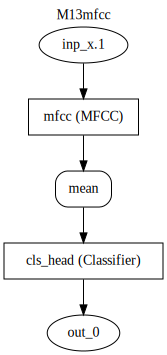

In [50]:
input_shape = (1,1,16000)
model.to(device)
input = torch.rand(input_shape).to(device)
display_module(
    model, input, 
    classes_to_visit={})

aten::matmul %10 : Float(1, 1, 122, 40, strides=[4880, 4880, 40, 1], requires_grad=0, device=cuda:0) = aten::matmul(%9, %dct_mat), scope: __module.mfcc # /opt/anaconda3/envs/audio/lib/python3.9/site-packages/torchaudio/transforms/_transforms.py:707:0

aten::mean %x : Float(1, 40, strides=[40, 1], requires_grad=0, device=cuda:0) = aten::mean(%x.7, %197, %198, %199) # /opt/anaconda3/envs/audio/lib/python3.9/site-packages/einops/_backends.py:247:0



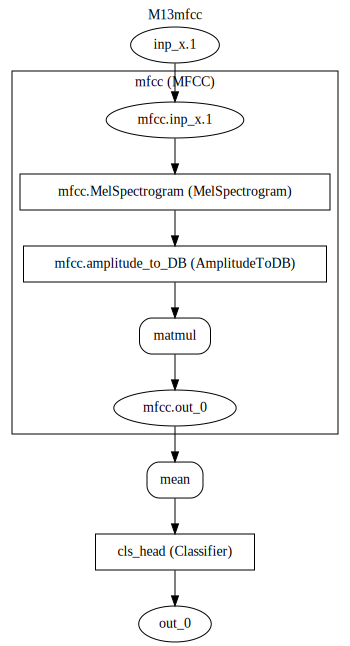

In [51]:
display_module(
    model, input, 
    classes_to_visit={"MFCC"})

aten::matmul %10 : Float(1, 1, 122, 40, strides=[4880, 4880, 40, 1], requires_grad=0, device=cuda:0) = aten::matmul(%9, %dct_mat), scope: __module.mfcc # /opt/anaconda3/envs/audio/lib/python3.9/site-packages/torchaudio/transforms/_transforms.py:707:0

aten::mean %x : Float(1, 40, strides=[40, 1], requires_grad=0, device=cuda:0) = aten::mean(%x.7, %197, %198, %199) # /opt/anaconda3/envs/audio/lib/python3.9/site-packages/einops/_backends.py:247:0



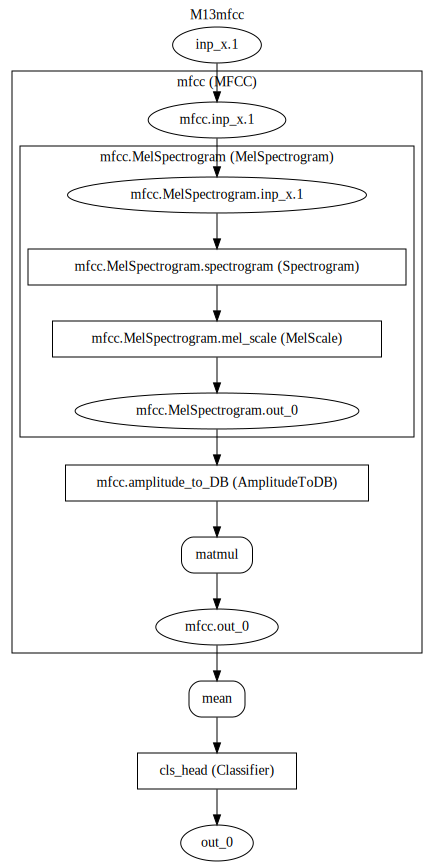

In [52]:
display_module(
    model, input, 
    classes_to_visit={"MFCC", "MelSpectrogram"})

aten::matmul %10 : Float(1, 1, 122, 40, strides=[4880, 4880, 40, 1], requires_grad=0, device=cuda:0) = aten::matmul(%9, %dct_mat), scope: __module.mfcc # /opt/anaconda3/envs/audio/lib/python3.9/site-packages/torchaudio/transforms/_transforms.py:707:0

aten::mean %x : Float(1, 40, strides=[40, 1], requires_grad=0, device=cuda:0) = aten::mean(%x.7, %197, %198, %199) # /opt/anaconda3/envs/audio/lib/python3.9/site-packages/einops/_backends.py:247:0



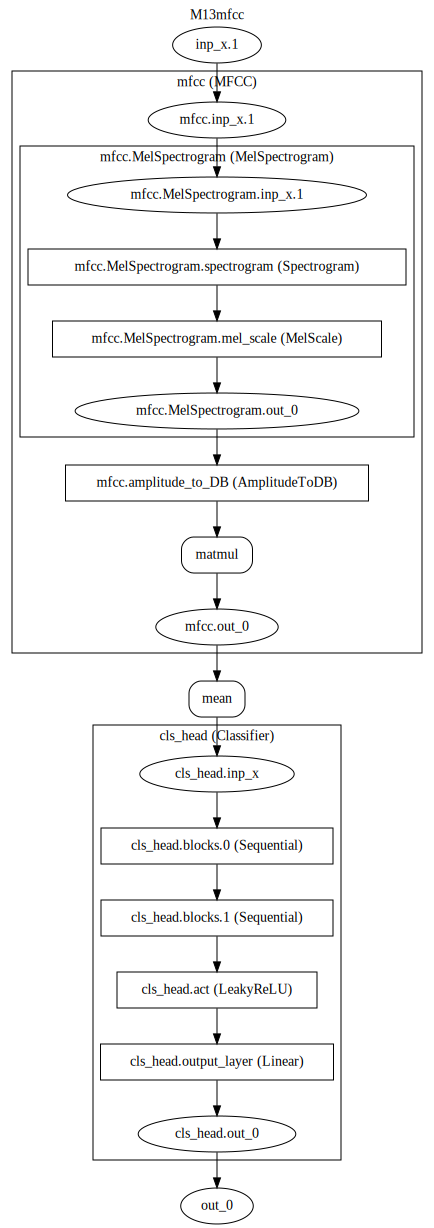

In [53]:
display_module(
    model, input, 
    classes_to_visit={"MFCC", "MelSpectrogram", "Classifier"})

In [54]:
# del model
# del best_model
# gc.collect()

737